# IVOL Puzzle & Arbitrage Asymmetry

This project aims to study the relationship between idiosyncratic volatility and expected return on equities. It attempts to recreate the study done by Stambaugh et al in 2015, with updated dataset up to 2024.

Idiosyncratic volatility is defined as the volatility of residuals when historical returns are regressed against Fama-French 3 factors. In line with Stambaugh's approach, we calculate IVOL over a historical period of one month. This yields a time series of IVOL values for each stock in our universe. 

At the same time, we use a composite, cross sectional measure for mispricing based on 10 return anomalies (the financial distress score is not easily retrievable). Each return anomaly is a time series object for each stock in our universe. To arrive at a composite measure for each time stamp, for each return anomaly, we rank each stock by the return anomaly. This yields 10 different rankings for each stock on any given day. We take the arithmetic mean of the 10 rankings to be the composite cross sectional measure of mispricing. 

With IVOL and mispricing measure, for each date, we sort stocks on IVOL and mispricing, grouping into 5 groups along each dimension. This forms 25 different baskets of stocks. We form each into a value-weighted portfolio. We then calculate the return on this portfolio for the next month, and regress against fama-french 3 factors to find the return that survive factor adjustment. 




## Notebook Set Up

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np
import seaborn as sns
import wrds
import statsmodels.api as sm
from scipy.stats import percentileofscore

plt.style.use('seaborn-v0_8-notebook')
eps = 1e-8
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = [10, 6]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['figure.autolayout'] = True

conn = wrds.Connection()
start = "1965-01-01"
end = "2025-01-01"

Loading library list...
Done


## Security identification
In line with Stambaugh et al's methodology, we use all NYSE/AMex/NASDAQ stocks with share prices greater than five dollars. We expand the dataset to cover up to 2024.

The code used to extract all tickers from the three relevant exchanges was 

```python
tickers = conn.raw_sql(
    f"""
    SELECT permno, ticker, namedt
    FROM crsp.msenames
    WHERE namedt BETWEEN '{start}' AND '{end}'
    AND exchcd in (1, 2, 3)
    """
)
```

From documentation, we understand that PERMNO is a unique five-digit permanent identifier assigned by CRSP to each security in the file. Unlike CUSIP, TICKER, and COMNAM, the PERMNO neither changes during an issue's trading history, nor is reassigned after an issue ceases trading. The user may track a security through its entire trading history in CRSP's files with one PERMNO, regardless of name changes or capital structure changes. A security that is included on both CRSP's Nasdaq and NYSE/AMEX files will have the same CRSP permanent number in both files.

Therefore, we have elected to work with `permnos` when identifying securities, instead of using individual tickers


## IVOL calculation

To calculate idiosyncratic volatility, we retrieved daily FF 3 factors. 

```python
factors = conn.raw_sql(
    f"""
    SELECT date, mktrf, smb, hml, rf
    FROM ff.factors_daily
    WHERE date BETWEEN '{start}' AND '{end}'
    """,
    date_cols = ['date']
).set_index('date')

factors = (
    factors.replace([np.inf, -np.inf], np.nan)
    .fillna(0)
    .astype(float)
)
```

We want a time-series at month-end frequency for each security in our universe, where `ivol_df.loc[t, p]` refers to the volatility of the residuals after regressing the daily returns for security `p` for month `t` against FF 3 factors. 

```python
ivol_df = pd.DataFrame(
    index = month_end_dates,
    columns = tickers['permno'].unique()
)

for i, permno in enumerate(ivol_df.columns[:100]):
    ret_df = (
        conn.raw_sql(
        f"""
        SELECT date, ret
        FROM crsp.dsf
        WHERE date BETWEEN '{start}' AND '{end}'
        AND permno = {permno}
        """,
        date_cols = ['date'])
        .set_index('date')
        .merge(
            factors,
            left_index=True,
            right_index=True,
            how='left'
        )
    )
    ret_df['ex_ret'] = ret_df['ret'] - ret_df['rf']

    for idx in ivol_df.index:
        time_range_mask = (
            (ret_df.index >= idx - pd.DateOffset(months = 1)) * (ret_df.index <= idx)
        )
        X = np.asarray(
            ret_df[['mktrf', 'smb', 'hml']][time_range_mask]
        )
        y = np.asarray(
            ret_df[['ex_ret']][time_range_mask]
        )

        if X.shape[0] != 0:
            X = sm.add_constant(X)
            model = sm.OLS(y, X).fit()
            ivol = np.std(
                model.resid
            )
            ivol_df.loc[idx, col] = ivol


ivol_df = pd.read_csv('./Data/full_ivol_df.csv', index_col=0)
```

## IVOL EDA

In [9]:
ivol_df = pd.read_csv('./Data/full_ivol_df.csv', index_col=0)
ivol_df.index = pd.to_datetime(ivol_df.index)
ivol_df.columns = ivol_df.columns.astype(int)
ivol_df

,83264,63618,10896,69906,79030,11233,44127,86580,91786,88837,...,56120,31713,85792,83586,89403,81454,79163,86036,92970,19812
1965-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.011945,NaN,NaN,NaN,NaN,NaN,NaN,0.025849,0.009253,0.013778,...,NaN,NaN,0.015452,NaN,0.018388,NaN,NaN,NaN,NaN,0.042034
2024-09-30,0.010587,NaN,NaN,NaN,NaN,NaN,NaN,0.011175,0.011429,0.010877,...,NaN,NaN,0.012494,NaN,0.010137,NaN,NaN,NaN,NaN,0.162169
2024-10-31,0.007728,NaN,NaN,NaN,NaN,NaN,NaN,0.016819,0.010310,0.047612,...,NaN,NaN,0.008540,NaN,0.009744,NaN,NaN,NaN,NaN,0.045123
2024-11-30,0.008987,NaN,NaN,NaN,NaN,NaN,NaN,0.017378,0.012528,0.048934,...,NaN,NaN,0.010319,NaN,0.024362,NaN,NaN,NaN,NaN,0.108532


We visualize the IVOL for Apple, Microsoft and Intuitive Surgical.

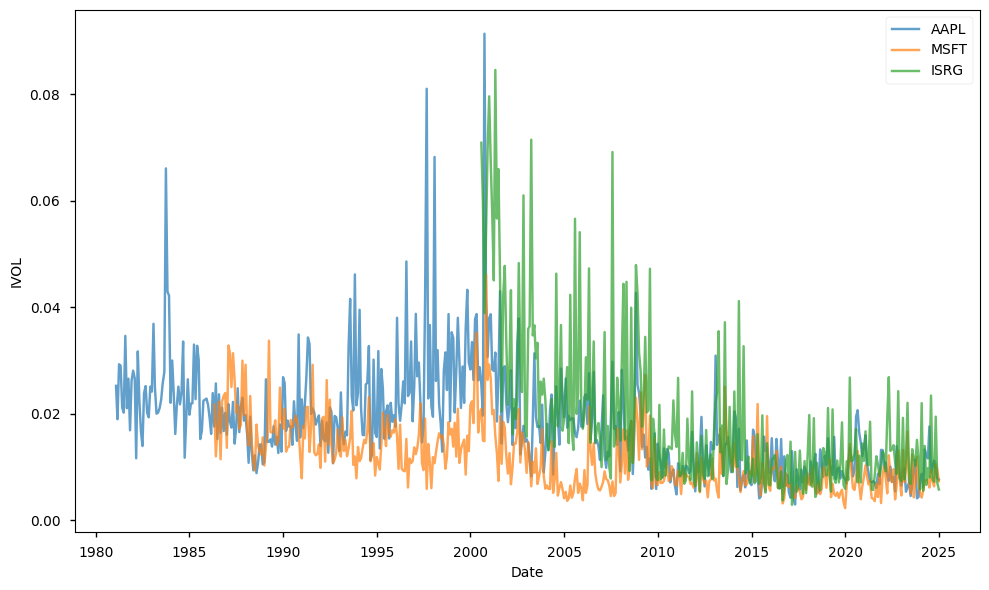

In [5]:
tickers = ['AAPL', 'MSFT', 'ISRG']
tickers_permno_map = conn.raw_sql(
    f"""
    SELECT DISTINCT permno, ticker
    FROM crsp.msenames
    WHERE ticker in ({','.join(["'" + t + "'" for t in tickers])})
    """
)
tickers_permno_map

fig, ax = plt.subplots(1, 1, figsize = (10, 6))

for ticker in tickers:
    permno = tickers_permno_map[
        tickers_permno_map['ticker'] == ticker
    ]['permno'].iloc[0]
    ax.plot(
        ivol_df[str(permno)],
        label = ticker,
        alpha = .7
    )

ax.set_xlabel('Date')
ax.set_ylabel('IVOL')
ax.legend()

plt.tight_layout()
plt.show()

We visualize the aggregate IVOL across all securities.

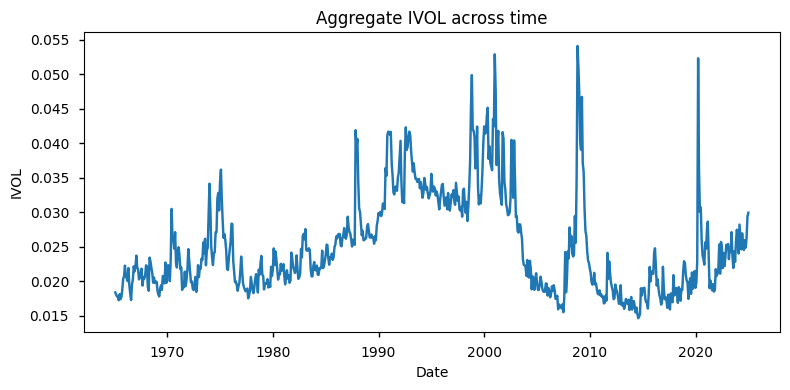

In [7]:
ivol_by_date = ivol_df.apply(lambda x: x.mean(), axis = 1)

fig, ax = plt.subplots(1, 1, figsize = (8, 4))
ax.plot(
    ivol_by_date
)
ax.set_xlabel('Date')
ax.set_ylabel('IVOL')

ax.set_title("Aggregate IVOL across time")

plt.tight_layout()
plt.show()

We visualize the IVOL for 10 randomly picked securities.

Text(0.5, 1.0, '10 randomly picked IVOLs')

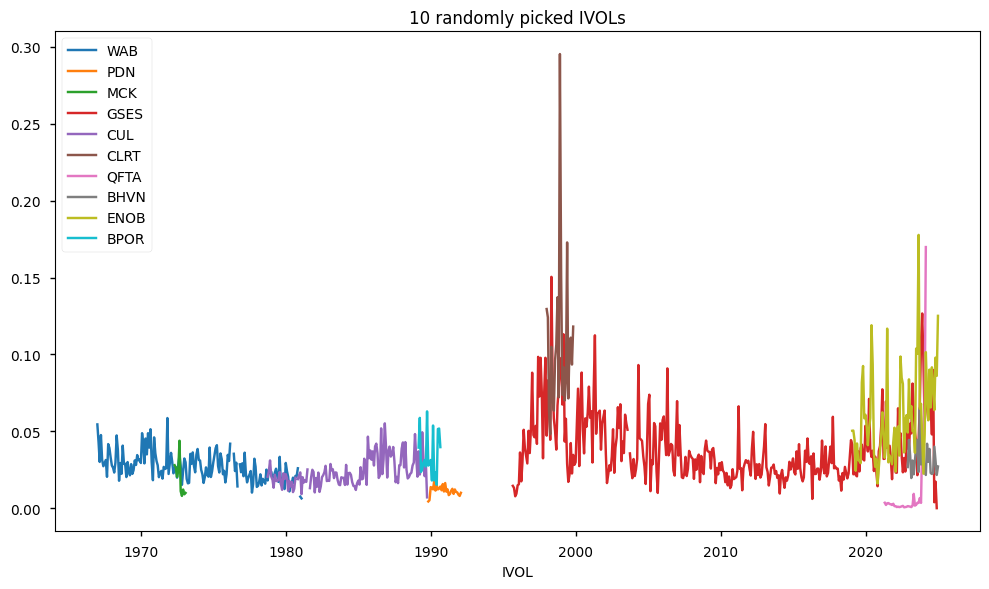

In [8]:
fig, ax = plt.subplots(1, 1)
for rng_col in np.random.randint(0, ivol_df.shape[1], size = 10):
    ticker = conn.raw_sql(
        f"""
            SELECT DISTINCT ticker
            FROM crsp.msenames
            WHERE permno = {ivol_df.columns[rng_col]}
        """
    )['ticker'][0]
    ax.plot(
        ivol_df.iloc[:, rng_col],
        label = ticker
    )
ax.set_xlabel('Date')
ax.set_xlabel('IVOL')
ax.legend()
ax.set_title("10 randomly picked IVOLs")

## IVOL Long Short Strategy

We consider a LS strategy where we long the 10% lowest IVOL stocks every month, and short the 10% highest IVOL stocks every month. If there is truly a negative IVOL effect on expected return, this strategy should generate excess returns. 

In [10]:
quantile_low = 0.10
quantile_high = 0.90

long_short_dict = {}

for date, row in ivol_df.iterrows():
    print("======" * 10)
    ivol_today = row.dropna()

    prices = conn.raw_sql(
        f"""
        SELECT permno
        FROM crsp.msf
        WHERE date =  '{date.strftime("%Y-%m-%d")}'
        AND prc >= 5
        """
    ).set_index('permno')
    if prices.shape[0] == 0:
        prices = conn.raw_sql(
            f"""
                SELECT DISTINCT ON (permno) permno, prc, date
                FROM crsp.msf
                WHERE date <= '{date.strftime("%Y-%m-%d")}'
                ORDER BY permno, date DESC
            """
        )

        prices = prices[prices['prc']>=5].set_index("permno")

    ivol_filtered = ivol_today[ivol_today.index.isin(prices.index)]
    
    if len(ivol_filtered) < 10:
        print(f"Skipping {date},  not enough tradeable securities")
        continue

    low_thresh = ivol_filtered.quantile(quantile_low)
    high_thresh = ivol_filtered.quantile(quantile_high)
    print(f"low threshold: {low_thresh:.4f}, high threshold: {high_thresh:.4f}")

    long_stocks = ivol_filtered[ivol_filtered <= low_thresh].index.tolist()
    short_stocks = ivol_filtered[ivol_filtered >= high_thresh].index.tolist()

    print(
        f"long leg mean IVOL: {ivol_df.loc[date, long_stocks].mean():.4f}"
    )
    print(
        f"short leg mean IVOL: {ivol_df.loc[date, short_stocks].mean():.4f}"
    )

    print(f"Processed {date}, {len(ivol_filtered)} total, {len(long_stocks)} longs, {len(short_stocks)} shorts")

    long_short_dict[date] = {
        'long': long_stocks,
        'short': short_stocks
    }


ls_returns = []

for date, positions in long_short_dict.items():
    next_month = (date + pd.offsets.MonthEnd(1)).strftime("%Y-%m-%d")

    tickers = positions['long'] + positions['short']

    ret_data = conn.raw_sql(
        f"""
        SELECT permno, ret
        FROM crsp.msf
        WHERE date = '{next_month}'
        """
    )

    long_returns = ret_data[ret_data['permno'].isin(positions['long'])]['ret']
    short_returns = ret_data[ret_data['permno'].isin(positions['short'])]['ret']

    if len(long_returns) == 0 or len(short_returns) == 0:
        continue

    # we work with equal-weighted portfolio for now
    long_ret = long_returns.mean()
    short_ret = short_returns.mean()

    ls_return = long_ret - short_ret

    ls_returns.append({
        'date': date,
        'long_ret': long_ret,
        'short_ret': short_ret,
        'ls_ret': ls_return
    })
    print(f"Processed {date}, LS return: {ls_return}")

ls_df = pd.DataFrame(ls_returns).set_index('date')

low threshold: 0.0067, high threshold: 0.0258
long leg mean IVOL: 0.0055
short leg mean IVOL: 0.0349
Processed 1965-01-31 00:00:00, 1471 total, 148 longs, 148 shorts
low threshold: 0.0068, high threshold: 0.0267
long leg mean IVOL: 0.0057
short leg mean IVOL: 0.0352
Processed 1965-02-28 00:00:00, 1488 total, 149 longs, 149 shorts
low threshold: 0.0064, high threshold: 0.0264
long leg mean IVOL: 0.0055
short leg mean IVOL: 0.0346
Processed 1965-03-31 00:00:00, 1469 total, 147 longs, 147 shorts
low threshold: 0.0064, high threshold: 0.0263
long leg mean IVOL: 0.0053
short leg mean IVOL: 0.0345
Processed 1965-04-30 00:00:00, 1526 total, 153 longs, 153 shorts
low threshold: 0.0065, high threshold: 0.0254
long leg mean IVOL: 0.0055
short leg mean IVOL: 0.0343
Processed 1965-05-31 00:00:00, 1487 total, 149 longs, 149 shorts
low threshold: 0.0081, high threshold: 0.0244
long leg mean IVOL: 0.0068
short leg mean IVOL: 0.0314
Processed 1965-06-30 00:00:00, 1512 total, 152 longs, 152 shorts
low 

In [17]:
calendar_month_ends = ivol_df.index
crsp_month_ends = conn.raw_sql(
    """
    SELECT DISTINCT date
    FROM crsp.msf
    WHERE date BETWEEN '1965-01-01' AND '2025-01-01'
    ORDER BY date
    """
)['date']
crsp_month_ends = pd.to_datetime(crsp_month_ends)
calendar_to_crsp_map = {}
for cal_date in calendar_month_ends:
    same_month_crsp = crsp_month_ends[
        (crsp_month_ends.dt.year == cal_date.year) &
        (crsp_month_ends.dt.month == cal_date.month)
    ]
    calendar_to_crsp_map[cal_date] = same_month_crsp.max() if not same_month_crsp.empty else pd.NaT
calendar_to_crsp_map = pd.Series(calendar_to_crsp_map)

calendar_to_crsp_map

1965-01-31   1965-01-29
1965-02-28   1965-02-26
1965-03-31   1965-03-31
1965-04-30   1965-04-30
1965-05-31   1965-05-28
                ...    
2024-08-31   2024-08-30
2024-09-30   2024-09-30
2024-10-31   2024-10-31
2024-11-30   2024-11-29
2024-12-31   2024-12-31
Length: 720, dtype: datetime64[ns]

In [206]:
quantile_low = 0.10
quantile_high = 0.90
long_short_dict = {}

for date, row in ivol_df.iterrows():
    print("=" * 60)
    print(f"Processing {date.strftime('%Y-%m-%d')}")

    ivol_today = row.dropna()

    crsp_price_date = calendar_to_crsp_map.get(date)

    if pd.isna(crsp_price_date):
        print(f"Skipping {date} — no mapped CRSP date available")
        continue

    crsp_price_date_str = crsp_price_date.strftime("%Y-%m-%d")

    permnos_filtered = conn.raw_sql(
        f"""
        SELECT permno
        FROM crsp.msf
        WHERE date = '{crsp_price_date_str}'
        AND prc >= 5
        """
    ).set_index('permno')

    if permnos_filtered.shape[0] == 0:
        print(f"Skipping {date} — no tradable stocks at {crsp_price_date_str}")
        continue

    ivol_filtered = ivol_today[ivol_today.index.isin(permnos_filtered.index)]

    if len(ivol_filtered) < 10:
        print(f"Skipping {date} — fewer than 10 tradable securities")
        continue

    low_thresh = ivol_filtered.quantile(quantile_low)
    high_thresh = ivol_filtered.quantile(quantile_high)

    long_stocks = ivol_filtered[ivol_filtered <= low_thresh].index.tolist()
    short_stocks = ivol_filtered[ivol_filtered >= high_thresh].index.tolist()

    print(f"Low threshold: {low_thresh:.4f}, High threshold: {high_thresh:.4f}")
    print(f"Long IVOL mean: {ivol_filtered[long_stocks].mean():.4f}")
    print(f"Short IVOL mean: {ivol_filtered[short_stocks].mean():.4f}")
    print(f"{len(ivol_filtered)} total | {len(long_stocks)} long | {len(short_stocks)} short")

    long_short_dict[date] = {
        'long': long_stocks,
        'short': short_stocks
    }


ls_returns = []

for date, positions in long_short_dict.items():
    crsp_ret_date = calendar_to_crsp_map.get(date + pd.offsets.MonthEnd(1))

    if pd.isna(crsp_ret_date):
        print(f"Skipping {date} — no CRSP return date for next month")
        continue

    crsp_ret_date_str = crsp_ret_date.strftime("%Y-%m-%d")
    tickers = positions['long'] + positions['short']

    ret_data = conn.raw_sql(
        f"""
        SELECT permno, ret
        FROM crsp.msf
        WHERE date = '{crsp_ret_date_str}'
        """
    )

    long_returns = ret_data[ret_data['permno'].isin(positions['long'])]['ret']
    short_returns = ret_data[ret_data['permno'].isin(positions['short'])]['ret']

    if long_returns.empty or short_returns.empty:
        print(f"Skipping {date} — missing returns for long or short leg")
        continue

    long_ret = long_returns.mean()
    short_ret = short_returns.mean()
    ls_ret = long_ret - short_ret

    ls_returns.append({
        'date': date,
        'long_ret': long_ret,
        'short_ret': short_ret,
        'ls_ret': ls_ret
    })

    print(f"Processed {date}, LS return: {ls_ret:.4f}")

ls_df = pd.DataFrame(ls_returns).set_index('date')

Processing 1965-01-31
Low threshold: 0.0067, High threshold: 0.0258
Long IVOL mean: 0.0055
Short IVOL mean: 0.0349
1471 total | 148 long | 148 short
Processing 1965-02-28
Low threshold: 0.0068, High threshold: 0.0267
Long IVOL mean: 0.0057
Short IVOL mean: 0.0352
1488 total | 149 long | 149 short
Processing 1965-03-31
Low threshold: 0.0064, High threshold: 0.0264
Long IVOL mean: 0.0055
Short IVOL mean: 0.0346
1469 total | 147 long | 147 short
Processing 1965-04-30
Low threshold: 0.0064, High threshold: 0.0263
Long IVOL mean: 0.0053
Short IVOL mean: 0.0345
1526 total | 153 long | 153 short
Processing 1965-05-31
Low threshold: 0.0065, High threshold: 0.0254
Long IVOL mean: 0.0055
Short IVOL mean: 0.0343
1487 total | 149 long | 149 short
Processing 1965-06-30
Low threshold: 0.0081, High threshold: 0.0244
Long IVOL mean: 0.0068
Short IVOL mean: 0.0314
1512 total | 152 long | 152 short
Processing 1965-07-31
Low threshold: 0.0071, High threshold: 0.0250
Long IVOL mean: 0.0059
Short IVOL mean

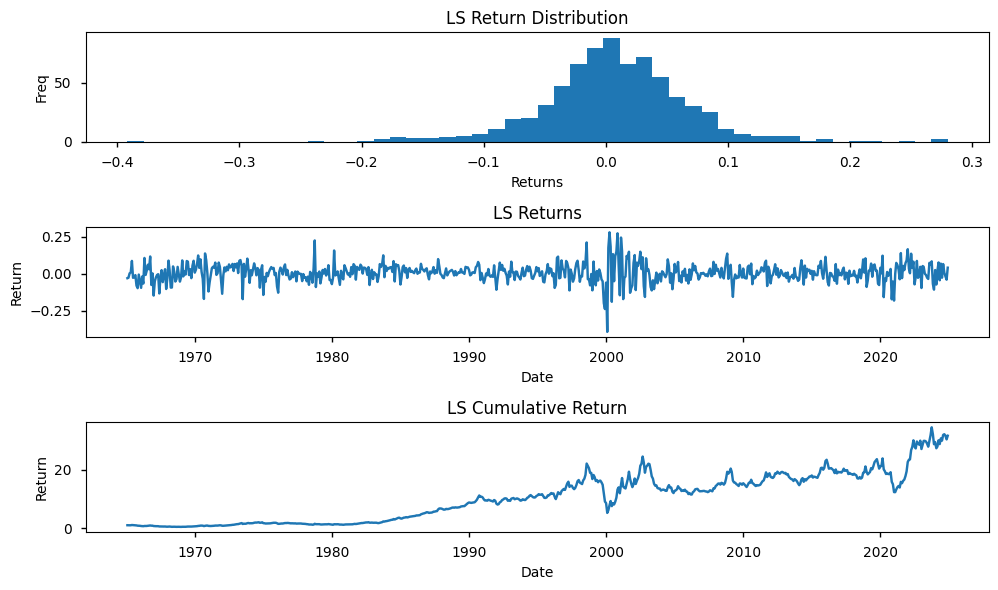

Text(0.5, 1.0, 'Cumulative Return')

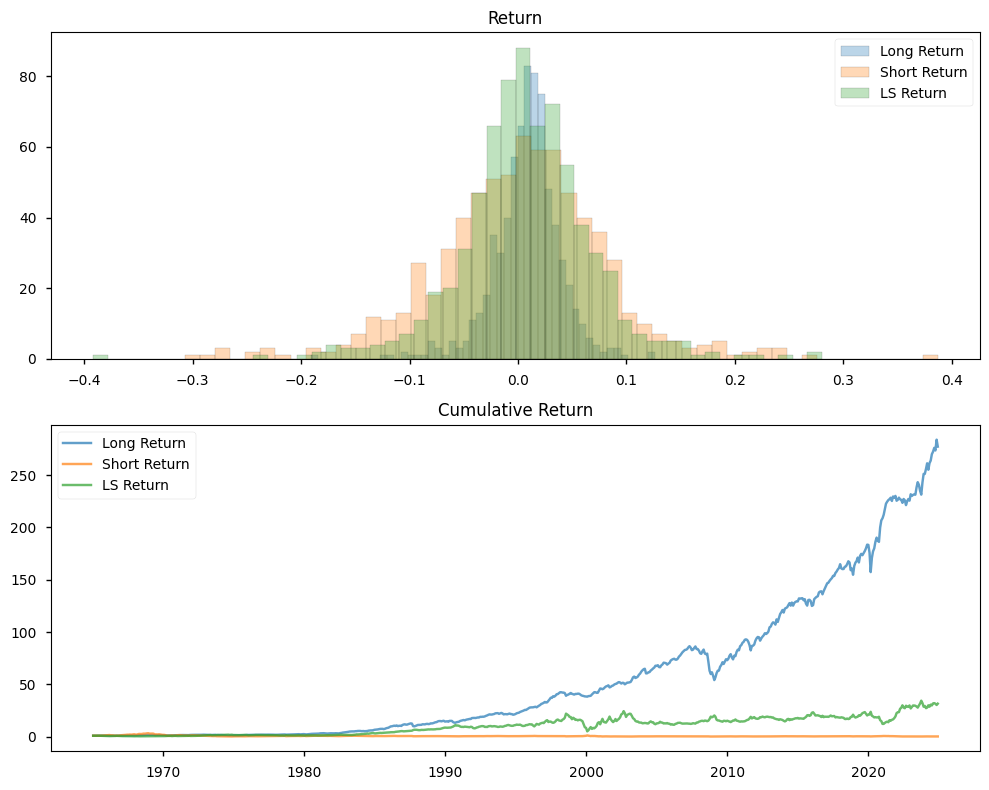

In [207]:
fig, axes = plt.subplots(3, 1, figsize= (10, 6))
axes[0].hist(
    ls_df['ls_ret'],
    bins = 50,
)

axes[0].set_xlabel("Returns")
axes[0].set_ylabel("Freq")

axes[1].plot(
    ls_df['ls_ret']
)

axes[1].set_xlabel("Date")
axes[1].set_ylabel("Return")
axes[1].set_title("LS Returns")

axes[2].plot(
    (ls_df['ls_ret'] + 1).cumprod()
)

axes[2].set_xlabel("Date")
axes[2].set_ylabel("Return")

axes[0].set_title("LS Return Distribution")
axes[2].set_title("LS Cumulative Return")

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 1, figsize = (10, 8))

axes[0].hist(
    ls_df['long_ret'],
    label = "Long Return",
    alpha = .3,
    bins= 50,
    edgecolor= 'black',
)

axes[0].hist(
    ls_df['short_ret'],
    label = "Short Return",
    alpha = .3,
    bins= 50,
    edgecolor= 'black',
)

axes[0].hist(
    ls_df['ls_ret'],
    label = "LS Return",
    alpha = .3,
    bins= 50,
    edgecolor= 'black',
)

axes[0].legend()

axes[0].set_title("Return")

axes[1].plot(
    (ls_df['long_ret'] + 1).cumprod(),
    label = "Long Return",
    alpha = .7
)

axes[1].plot(
    (ls_df['short_ret'] + 1).cumprod(),
    label = "Short Return",
    alpha = .7
)

axes[1].plot(
    (ls_df['ls_ret'] + 1).cumprod(),
    label = "LS Return",
    alpha = .7
)

axes[1].legend()
axes[1].set_title("Cumulative Return")


In [208]:
factors = (
    conn.raw_sql(
        f"""
        SELECT date, mktrf, smb, hml, rf
        FROM ff.factors_monthly
        WHERE date BETWEEN '{start}' AND '{end}'
        """,
        date_cols = ['date']
    )
    .set_index('date')
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
    .astype(float)
)

factors.index = factors.index + pd.offsets.MonthEnd(0)

ls_df_merged = ls_df.merge(
    factors,
    left_index = True,
    right_index = True
)

y = np.asarray(ls_df_merged['ls_ret'] - ls_df_merged['rf'])
X = np.asarray(
    ls_df_merged[['mktrf', 'smb', 'hml']]
)
X = sm.add_constant(X)

res = sm.OLS(y, X).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     4.901
Date:                Mon, 21 Apr 2025   Prob (F-statistic):            0.00223
Time:                        20:43:30   Log-Likelihood:                 990.49
No. Observations:                 719   AIC:                            -1973.
Df Residuals:                     715   BIC:                            -1955.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.002      1.461      0.145      -0.001       0.008
x1            -0.0968      0.054     -1.806      0.071      -0.202       0.008
x2            -0.1005      0.078     -1.292      0.197      -0.253       0.052
x3             0.1679      0.078      2.164      0.031       0.016       0.320
==============================================================================
Omnibus:                       87.367   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              557.349
Skew:                          -0.306   Prob(JB):                    9.40e-122
Kurtosis:                       7.270   Cond. No.                         35.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

TODO: add write up on IVOL LS strategy return

## Retrieving return anomalies

The 9 return anomalies are retrieved in a separate notebook.

## Generating aggregate mispricing measure

To generate the aggregate mispricing measure, we follow Stambaugh et al's methodology. For each return anomaly, we rank all securities for which the anomaly can be calculated. 

For each date, for each anomaly, we sort all stocks from most underpiced to most overpriced. After assigning percentile rankings to each stock for each return anomaly, we filter for stocks that have at least 5 return anomalies that can be calculated. The overall aggregate mispricing measure is the arithmetic mean of the individual return anomaly scores.

In [58]:
anomalies_df = pd.read_csv('./Data/anomalies_raw_new.csv')
anomalies_df

,date,variable,10003,10007,10010,10016,10017,10021,10027,10031,...,93371,93374,93384,93390,93392,93395,93397,93427,93428,93435
0,1965-01-31,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1965-02-28,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1965-03-31,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1965-04-30,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1965-05-31,at_gr1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,2024-08-31,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.125307,0.018117,NaN,NaN,NaN,NaN,0.453436,0.371898,NaN,NaN
8636,2024-09-30,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.686486,0.159861,NaN,NaN,NaN,NaN,0.663626,0.462309,NaN,NaN
8637,2024-10-31,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.321839,0.328630,NaN,NaN,NaN,NaN,0.874680,0.525419,NaN,NaN
8638,2024-11-30,ret_12_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.093846,0.114412,NaN,NaN,NaN,NaN,0.710237,0.488388,NaN,NaN


In [59]:
anomalies_df.set_index(['date', 'variable'], inplace=True)
anomalies_df.columns = anomalies_df.columns.astype(int)

columns_to_reverse = [
    'niq_at', # return on assets
    'ret_12_1', # momentum
    'gp_at'
]

for idx in anomalies_df.index:
    var = idx[1]
    if var in columns_to_reverse:
        anomalies_df.loc[idx] = - anomalies_df.loc[idx]

anomalies_pct = pd.DataFrame(
    index = anomalies_df.index,
    columns = anomalies_df.columns
)
for i, idx in enumerate(anomalies_pct.index):
    print(f"Processing {i} out of {anomalies_pct.shape[0]}")
    anomalies_pct.loc[idx] = anomalies_df.loc[idx].rank(pct=True)

Processing 0 out of 8640
Processing 1 out of 8640
Processing 2 out of 8640
Processing 3 out of 8640
Processing 4 out of 8640
Processing 5 out of 8640
Processing 6 out of 8640
Processing 7 out of 8640
Processing 8 out of 8640
Processing 9 out of 8640
Processing 10 out of 8640
Processing 11 out of 8640
Processing 12 out of 8640
Processing 13 out of 8640
Processing 14 out of 8640
Processing 15 out of 8640
Processing 16 out of 8640
Processing 17 out of 8640
Processing 18 out of 8640
Processing 19 out of 8640
Processing 20 out of 8640
Processing 21 out of 8640
Processing 22 out of 8640
Processing 23 out of 8640
Processing 24 out of 8640
Processing 25 out of 8640
Processing 26 out of 8640
Processing 27 out of 8640
Processing 28 out of 8640
Processing 29 out of 8640
Processing 30 out of 8640
Processing 31 out of 8640
Processing 32 out of 8640
Processing 33 out of 8640
Processing 34 out of 8640
Processing 35 out of 8640
Processing 36 out of 8640
Processing 37 out of 8640
Processing 38 out of 8

In [60]:
aggregated = {}

for i, stock in enumerate(anomalies_pct.columns):
    print(f"Processing column {i}/{anomalies_pct.shape[1]}", end = '\r')
    temp = (
        anomalies_pct[stock]
        .unstack('variable') 
        .apply(lambda row: row.dropna().mean() if row.dropna().shape[0] >= 5 else np.nan, axis=1)
    )
    aggregated[stock] = temp

aggregate_mispricing_df = pd.concat(aggregated, axis=1)
aggregate_mispricing_df.index = pd.to_datetime(aggregate_mispricing_df.index)

In [61]:
aggregate_mispricing_df.to_csv('./Data/aggregate_mispricing.csv')

## Double sorting stocks on IVOL and mispricing

The next section intends to form 25 value-weighted portfolio of stocks double sorted on IVOL and mispricing measure. 

Along each dimension, we split our stocks into 5 quintiles. The naming scheme of our portfolio is as follows
- each security gets assigned a label 0-4 for mispricing, where 0 is the most overpriced and 4 is the most underpriced, let this be $l1$
- each security gets assigned a label 0-4 for IVOL, where 0 is the lowest IVOL and 4 is the highest IVOL,  let this be $l2$

The overall portfolio that each ticker falls under will be $k$
$$
k = 5 \times l1 + l2
$$

#### Sorting on IVOL

Since we previously calculated IVOLs for all securities, regardless of whether they meet our $5 trading price requirement, we want to filter these out. The filtering was done when we processed the return anomalies and mispricing measures, hence the difference in shape between `ivol_df` and `aggregate_mispricing_df`.

In [65]:
ivol_df = pd.read_csv('./Data/full_ivol_df.csv', index_col=0)
aggregate_mispricing_df = pd.read_csv('./Data/aggregate_mispricing.csv', index_col=0)

ivol_df.index = pd.to_datetime(ivol_df.index)
ivol_df.columns = ivol_df.columns.astype(int)

aggregate_mispricing_df.index = pd.to_datetime(aggregate_mispricing_df.index)
aggregate_mispricing_df.columns = aggregate_mispricing_df.columns.astype(int)

filtered_cols = ivol_df.columns[
    ivol_df.columns.isin(aggregate_mispricing_df.columns)
]

ivol_df = ivol_df[filtered_cols]
aggregate_mispricing_df = aggregate_mispricing_df[filtered_cols]

In [77]:
def map_quantile(x, quantiles):
    if x <= quantiles[0]:
        return 0
    elif x <= quantiles[1]:
        return 1
    elif x <= quantiles[2]:
        return 2
    elif x <= quantiles[3]:
        return 3
    else:
        return 4

def map_quantile_reversed(x, quantiles):
    if x <= quantiles[0]:
        return 4
    elif x <= quantiles[1]:
        return 3
    elif x <= quantiles[2]:
        return 2
    elif x <= quantiles[3]:
        return 1
    else:
        return 0
    
ivol_quintiles = pd.DataFrame(index=ivol_df.index, columns=filtered_cols)
mispricing_quintiles = pd.DataFrame(index=aggregate_mispricing_df.index, 
                                    columns=filtered_cols)

calendar_month_ends = pd.date_range('1965-01-01', '2025-01-01', freq='ME')
crsp_month_ends = conn.raw_sql(
    """
    SELECT DISTINCT date
    FROM crsp.msf
    WHERE date BETWEEN '1965-01-01' AND '2025-01-01'
    ORDER BY date
    """
)['date']
crsp_month_ends = pd.to_datetime(crsp_month_ends)

calendar_to_crsp_map = {}
for cal_date in calendar_month_ends:
    same_month_crsp = crsp_month_ends[
        (crsp_month_ends.dt.year == cal_date.year) & 
        (crsp_month_ends.dt.month == cal_date.month)
    ]
    if not same_month_crsp.empty:
        calendar_to_crsp_map[cal_date] = same_month_crsp.max()
    else:
        calendar_to_crsp_map[cal_date] = pd.NaT
calendar_to_crsp_map = pd.Series(calendar_to_crsp_map)


for idx in ivol_df.index:

    crsp_date = calendar_to_crsp_map[idx]
    permnos = conn.raw_sql(
        f"""
        SELECT permno
        FROM crsp.msf
        WHERE date = '{crsp_date.strftime("%Y-%m-%d")}'
        AND prc >= 5
        """
    ).set_index('permno')
    
    valid_permnos = ivol_df.columns[
        ivol_df.columns.isin(permnos.index)
    ]
    ivol_today = ivol_df.loc[idx, valid_permnos]
    mispricing_t = aggregate_mispricing_df.loc[idx, valid_permnos]
    valid_permnos = ivol_today.index[~(ivol_today.isna() | mispricing_t.isna())]

    print(f"Processing {idx} - {len(valid_permnos)} permnos ranked")

    # TODO run sorts together
    ivol_valid = ivol_today.loc[valid_permnos]
    ivol_q = np.quantile(ivol_valid, [0.2, 0.4, 0.6, 0.8])
    ivol_ranked = ivol_valid.apply(lambda x: map_quantile(x, ivol_q))
    ivol_quintiles.loc[idx, ivol_ranked.index] = ivol_ranked

    mispricing_valid = mispricing_t.loc[valid_permnos]
    mispricing_q = np.quantile(mispricing_valid, [0.2, 0.4, 0.6, 0.8])
    mispricing_ranked = mispricing_t.apply(lambda x: map_quantile_reversed(x, mispricing_q))
    mispricing_quintiles.loc[idx, mispricing_ranked.index] = mispricing_ranked


Processing 1965-01-31 00:00:00 - 1437 permnos ranked
Processing 1965-02-28 00:00:00 - 1451 permnos ranked
Processing 1965-03-31 00:00:00 - 1422 permnos ranked
Processing 1965-04-30 00:00:00 - 1486 permnos ranked
Processing 1965-05-31 00:00:00 - 1444 permnos ranked
Processing 1965-06-30 00:00:00 - 1465 permnos ranked
Processing 1965-07-31 00:00:00 - 1415 permnos ranked
Processing 1965-08-31 00:00:00 - 1473 permnos ranked
Processing 1965-09-30 00:00:00 - 1481 permnos ranked
Processing 1965-10-31 00:00:00 - 1516 permnos ranked
Processing 1965-11-30 00:00:00 - 1558 permnos ranked
Processing 1965-12-31 00:00:00 - 1588 permnos ranked
Processing 1966-01-31 00:00:00 - 1593 permnos ranked
Processing 1966-02-28 00:00:00 - 1659 permnos ranked
Processing 1966-03-31 00:00:00 - 1599 permnos ranked
Processing 1966-04-30 00:00:00 - 1600 permnos ranked
Processing 1966-05-31 00:00:00 - 1576 permnos ranked
Processing 1966-06-30 00:00:00 - 1571 permnos ranked
Processing 1966-07-31 00:00:00 - 1547 permnos 

In [78]:
ivol_quintiles.to_csv('./Data/ivol_quintiles.csv')
mispricing_quintiles.to_csv('./Data/mispricing_quintiles.csv')

In [79]:
ivol_quintiles = pd.read_csv('./Data/ivol_quintiles.csv', index_col=0)
mispricing_quintiles = pd.read_csv('./Data/mispricing_quintiles.csv', index_col=0)

ivol_quintiles.index = pd.to_datetime(ivol_quintiles.index)
mispricing_quintiles.index = pd.to_datetime(mispricing_quintiles.index)

ivol_quintiles.columns = ivol_quintiles.columns.astype(int)
mispricing_quintiles.columns = mispricing_quintiles.columns.astype(int)

In [80]:
#TODO: check if this is working 
mispricing_aligned = mispricing_quintiles[ivol_quintiles.columns]
portfolio_allocation = 5 * mispricing_aligned + ivol_quintiles

In [81]:
portfolio_allocation

,83264,63618,69906,79030,11233,44127,86580,91786,88837,88451,...,66480,56120,85792,83586,89403,81454,79163,86036,92970,19812
date,,,,,,,,,,,,,,,,,,,,,
1965-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,2.0,NaN,NaN,NaN,NaN,NaN,14.0,21.0,12.0,NaN,...,NaN,NaN,3.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN
2024-09-30,2.0,NaN,NaN,NaN,NaN,NaN,12.0,22.0,17.0,NaN,...,NaN,NaN,2.0,NaN,17.0,NaN,NaN,NaN,NaN,NaN
2024-10-31,1.0,NaN,NaN,NaN,NaN,NaN,13.0,22.0,9.0,NaN,...,NaN,NaN,6.0,NaN,21.0,NaN,NaN,NaN,NaN,NaN


After creating the 25 portfolios, now we value-weight them and calculate the return on each of the 25 portfolios.

In [82]:
source_df = pd.read_csv(
    './Data/me_prc_ret.csv',
    index_col=0
)
source_df['date'] = pd.to_datetime(source_df['date'])

market_equity_df = source_df[
    source_df['variable'] == 'me'
].drop(columns='variable').set_index('date')

market_equity_df.columns = market_equity_df.columns.astype(int)

prc_df = source_df[
    source_df['variable'] == 'prc'
].drop(columns='variable').set_index('date')
prc_df.columns = prc_df.columns.astype(int)

ret_df = source_df[
    source_df['variable'] == 'ret'
].drop(columns='variable').set_index('date')
ret_df.columns = ret_df.columns.astype(int)


In [84]:
portfolio_comp = pd.DataFrame(
    columns= np.arange(25),
    index = pd.date_range(
        '1965-01-01',
        '2025-01-01',
        freq = 'ME'
    )
)

for date in portfolio_comp.index:
    print(f"Processing {date}")
    for portfolio in portfolio_comp.columns:
        portfolio_comp.loc[date, portfolio] = np.asarray(portfolio_allocation.columns[
            portfolio_allocation.loc[date] == portfolio
        ])

portfolio_comp

Processing 1965-01-31 00:00:00
Processing 1965-02-28 00:00:00
Processing 1965-03-31 00:00:00
Processing 1965-04-30 00:00:00
Processing 1965-05-31 00:00:00
Processing 1965-06-30 00:00:00
Processing 1965-07-31 00:00:00
Processing 1965-08-31 00:00:00
Processing 1965-09-30 00:00:00
Processing 1965-10-31 00:00:00
Processing 1965-11-30 00:00:00
Processing 1965-12-31 00:00:00
Processing 1966-01-31 00:00:00
Processing 1966-02-28 00:00:00
Processing 1966-03-31 00:00:00
Processing 1966-04-30 00:00:00
Processing 1966-05-31 00:00:00
Processing 1966-06-30 00:00:00
Processing 1966-07-31 00:00:00
Processing 1966-08-31 00:00:00
Processing 1966-09-30 00:00:00
Processing 1966-10-31 00:00:00
Processing 1966-11-30 00:00:00
Processing 1966-12-31 00:00:00
Processing 1967-01-31 00:00:00
Processing 1967-02-28 00:00:00
Processing 1967-03-31 00:00:00
Processing 1967-04-30 00:00:00
Processing 1967-05-31 00:00:00
Processing 1967-06-30 00:00:00
Processing 1967-07-31 00:00:00
Processing 1967-08-31 00:00:00
Processi

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
1965-01-31,"[19377, 15624, 21792, 12183, 18956, 21776, 218...","[23851, 33873, 24985, 25056, 27473, 12650, 161...","[26550, 10161, 28150, 40635, 24432, 10495, 137...","[27596, 21274, 32707, 39108, 26059, 40360, 360...","[40694, 30525, 31616, 29049, 26673, 27633, 325...","[22840, 20626, 25953, 12431, 17742, 33099, 407...","[16432, 10436, 21960, 26403, 22461, 24870, 220...","[25574, 27377, 84751, 26534, 28230, 38930, 269...","[40643, 39597, 33283, 20757, 14250, 14867, 235...","[36310, 29321, 39589, 32854, 24598, 40600, 385...",...,"[21127, 36249, 31886, 38201, 28046, 12837, 133...","[20132, 18550, 14883, 22357, 32256, 39036, 212...","[13565, 20562, 40571, 12167, 28994, 21282, 249...","[36986, 27617, 19254, 14859, 31958, 32723, 394...","[34235, 35860, 30664, 33259, 20474, 38113, 224...","[34665, 10866, 33021, 23034, 21151, 13370, 262...","[34315, 28070, 38383, 17005, 15317, 19107, 375...","[38535, 22904, 32280, 35430, 25531, 24512, 368...","[39482, 40934, 26227, 30779, 26016, 31704, 412...","[28644, 34331, 20917, 36775, 29719, 29567, 326..."
1965-02-28,"[26606, 20626, 24985, 25056, 16432, 27473, 406...","[27596, 19377, 12650, 24432, 18622, 21776, 235...","[40694, 33873, 21274, 26550, 28150, 26403, 231...","[10161, 32707, 14867, 25953, 40360, 28409, 266...","[40643, 36310, 39108, 31616, 29049, 26729, 360...","[15050, 17566, 10436, 21960, 21821, 28230, 242...","[23851, 25574, 15624, 20132, 39300, 21792, 260...","[22840, 20757, 22357, 12431, 24002, 17128, 245...","[33283, 34032, 30525, 26534, 23544, 32272, 362...","[27895, 10938, 39132, 24598, 33240, 39095, 267...",...,"[21127, 14883, 36783, 19107, 15472, 29890, 131...","[22752, 28070, 18550, 20562, 31886, 38201, 390...","[34315, 13565, 18251, 21207, 21151, 25531, 235...","[36986, 39597, 19254, 33304, 27094, 24766, 307...","[34235, 34796, 40934, 22904, 31958, 31173, 330...","[10866, 40571, 32723, 32416, 13370, 39247, 315...","[28644, 14859, 12167, 23034, 17005, 32942, 103...","[27617, 34665, 26227, 32280, 36775, 84751, 131...","[39482, 34331, 35860, 39773, 30664, 21282, 350...","[17734, 41304, 20917, 39431, 36847, 26016, 317..."
1965-03-31,"[19377, 41443, 24985, 25056, 16432, 12183, 189...","[40694, 33873, 26606, 15624, 27377, 27473, 126...","[23851, 25574, 21274, 26550, 15317, 40790, 267...","[27596, 28150, 40635, 22461, 28230, 26673, 276...","[36310, 32707, 39108, 29049, 36003, 40715, 334...","[22840, 20626, 17566, 21960, 21573, 31886, 217...","[26403, 25953, 22955, 10495, 23536, 21143, 104...","[10161, 38287, 17742, 18622, 40299, 11981, 157...","[33283, 38607, 22357, 29321, 17822, 39589, 316...","[40360, 32854, 27545, 32504, 31536, 22824, 266...",...,"[21127, 18550, 14883, 17291, 13928, 15472, 117...","[19254, 36249, 15050, 14250, 26227, 36783, 176...","[34315, 34032, 20562, 40571, 18358, 15368, 322...","[34171, 40280, 14859, 35860, 24766, 16600, 273...","[27617, 34796, 28070, 17734, 41304, 22904, 319...","[39036, 13119, 26278, 34497, 19289, 11949, 234...","[34665, 10866, 33101, 39431, 40459, 32942, 332...","[39597, 38201, 27094, 36775, 17005, 23544, 297...","[34235, 39482, 28644, 39773, 32280, 30779, 299...","[20917, 23106, 26016, 21151, 29567, 32643, 412..."
1965-04-30,"[26606, 19377, 25056, 21127, 26550, 24432, 161...","[20626, 14883, 24870, 12183, 16600, 41590, 235...","[40694, 23851, 33873, 21274, 24985, 15624, 274...","[27596, 38607, 14867, 28150, 27895, 31616, 267...","[32707, 31886, 26331, 36003, 38543, 33435, 342...","[25574, 15050, 16432, 21960, 10786, 13928, 186...","[22840, 20757, 27377, 14250, 21573, 26403, 126...","[10161, 14859, 40635, 17742, 14891, 37807, 278...","[34032, 22904, 10436, 11260, 84751, 26534, 119...","[33283, 39108, 18358, 10938, 22429, 14349, 311...",...,"[18550, 39300, 15317, 35430, 13119, 16424, 154...","[19254, 36249, 22357, 24539, 28046, 39853, 121...","[38535, 13565, 17822, 12167, 39925, 31173, 362...","[34235, 27094, 39431, 29911, 27043, 23106, 235...","[40643, 34796, 28070, 17734, 39773, 

In [103]:
calendar_month_ends = pd.date_range('1965-01-01', '2025-01-01', freq='ME')
crsp_month_ends = conn.raw_sql(
    """
    SELECT DISTINCT date
    FROM crsp.msf
    WHERE date BETWEEN '1965-01-01' AND '2025-01-01'
    ORDER BY date
    """
)['date']
crsp_month_ends = pd.to_datetime(crsp_month_ends)

calendar_to_crsp_map = {}
for cal_date in calendar_month_ends:
    same_month_crsp = crsp_month_ends[
        (crsp_month_ends.dt.year == cal_date.year) & 
        (crsp_month_ends.dt.month == cal_date.month)
    ]
    if not same_month_crsp.empty:
        calendar_to_crsp_map[cal_date] = same_month_crsp.max()
    else:
        calendar_to_crsp_map[cal_date] = pd.NaT
calendar_to_crsp_map = pd.Series(calendar_to_crsp_map)

portfolio_ret = pd.DataFrame(
    columns=np.arange(25),
    index=calendar_month_ends
)

for i, d in enumerate(portfolio_ret.index[:-1]):
    print(f"Processing {d}")


    for p in portfolio_ret.columns:
        permnos_dp = portfolio_comp.loc[d, p]

        w_dp = market_equity_df.loc[d][permnos_dp]

        crsp_date = calendar_to_crsp_map.get(d + pd.offsets.MonthEnd(1))

        if pd.isna(crsp_date):
            print(f"No CRSP return data for {d + pd.offsets.MonthEnd(1)}")
            continue

        crsp_date_str = crsp_date.strftime("%Y-%m-%d")
        ret_data = conn.raw_sql(
            f"""
            SELECT permno, ret
            FROM crsp.msf
            WHERE date = '{crsp_date_str}'
            """
        ).set_index('permno')

        ret_dp = ret_data.loc[ret_data.index.isin(permnos_dp), 'ret']
        valid_returns = ret_dp.dropna()
        valid_weights = w_dp.loc[
            valid_returns.index
        ]

        valid_weights = valid_weights / valid_weights.sum()

        portfolio_ret.loc[d, p] = np.dot(valid_weights, valid_returns)
        print(f"{d}, {p} return: {portfolio_ret.loc[d, p]}")

Processing 1965-01-31 00:00:00
1965-01-31 00:00:00, 0 return: -0.0017922946864781274
1965-01-31 00:00:00, 1 return: 0.010382166167768983
1965-01-31 00:00:00, 2 return: 0.009962865869998835
1965-01-31 00:00:00, 3 return: 0.019158452428473038
1965-01-31 00:00:00, 4 return: 0.037689266016560787
1965-01-31 00:00:00, 5 return: -0.008133045309638483
1965-01-31 00:00:00, 6 return: 0.03572249995643293
1965-01-31 00:00:00, 7 return: 0.04834994578399706
1965-01-31 00:00:00, 8 return: 0.033500843432125206
1965-01-31 00:00:00, 9 return: 0.05498352926279236
1965-01-31 00:00:00, 10 return: -0.00723406759489416
1965-01-31 00:00:00, 11 return: 0.03347398536376538
1965-01-31 00:00:00, 12 return: 0.021901138318713646
1965-01-31 00:00:00, 13 return: 0.0462353444082994
1965-01-31 00:00:00, 14 return: 0.051724078686480324
1965-01-31 00:00:00, 15 return: 0.020320694461767177
1965-01-31 00:00:00, 16 return: 0.014768716927761959
1965-01-31 00:00:00, 17 return: 0.04422729324170344
1965-01-31 00:00:00, 18 retur

In [104]:
portfolio_ret

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
1965-01-31,-0.001792,0.010382,0.009963,0.019158,0.037689,-0.008133,0.035722,0.04835,0.033501,0.054984,...,0.020321,0.014769,0.044227,0.020533,0.031894,-0.000038,0.044184,0.027116,0.058181,0.013647
1965-02-28,-0.010812,-0.010946,-0.011094,-0.015143,0.016363,-0.02368,-0.007989,-0.03458,-0.016559,0.006146,...,-0.007062,0.006758,0.005109,0.022584,0.004226,-0.003118,0.001297,-0.002074,0.016284,0.012866
1965-03-31,0.024929,0.025021,0.036027,0.023862,0.057073,0.032709,0.035306,0.015347,0.039155,0.037379,...,0.038452,0.024476,0.043711,0.082163,0.024418,0.019868,0.013779,0.059762,0.065322,0.034635
1965-04-30,0.001111,-0.008755,-0.000838,-0.017006,0.023544,-0.014773,-0.00011,0.004251,-0.046961,-0.006308,...,-0.003247,0.002371,-0.012651,0.010626,-0.014202,-0.005831,-0.027605,-0.004625,-0.020237,-0.016432
1965-05-31,-0.036775,-0.049065,-0.057809,-0.095337,-0.159435,-0.026289,-0.053249,-0.051861,-0.084273,-0.111317,...,-0.057067,-0.043578,-0.058088,-0.091995,-0.124466,-0.052132,-0.071354,-0.089291,-0.081145,-0.130347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.018943,0.009514,0.053049,-0.011512,0.044152,0.017437,0.018267,0.005662,0.03435,0.076946,...,0.030063,0.019428,0.020646,0.007322,0.049314,0.019111,0.005547,0.015374,0.01223,0.103535
2024-09-30,-0.012503,-0.021422,-0.017739,-0.000914,-0.027695,0.002422,-0.029416,-0.007889,0.009437,-0.033246,...,-0.015116,-0.008388,-0.020539,-0.024977,0.049352,-0.01055,-0.020643,-0.015071,-0.052238,-0.011157
2024-10-31,0.056116,0.077248,0.033521,0.080521,0.265488,0.055783,0.091238,0.045566,0.075371,0.089762,...,0.055158,0.065457,0.0517,0.089568,0.000946,0.024169,0.051782,0.062835,0.085701,-0.013197
2024-11-30,-0.032048,-0.066058,-0.073253,-0.058866,0.0382,-0.052399,-0.013023,-0.036439,-0.062425,-0.044836,...,-0.053662,0.009738,0.016553,-0.038785,-0.027847,-0.034292,-0.048811,-0.051094,-0.04078,-0.045202


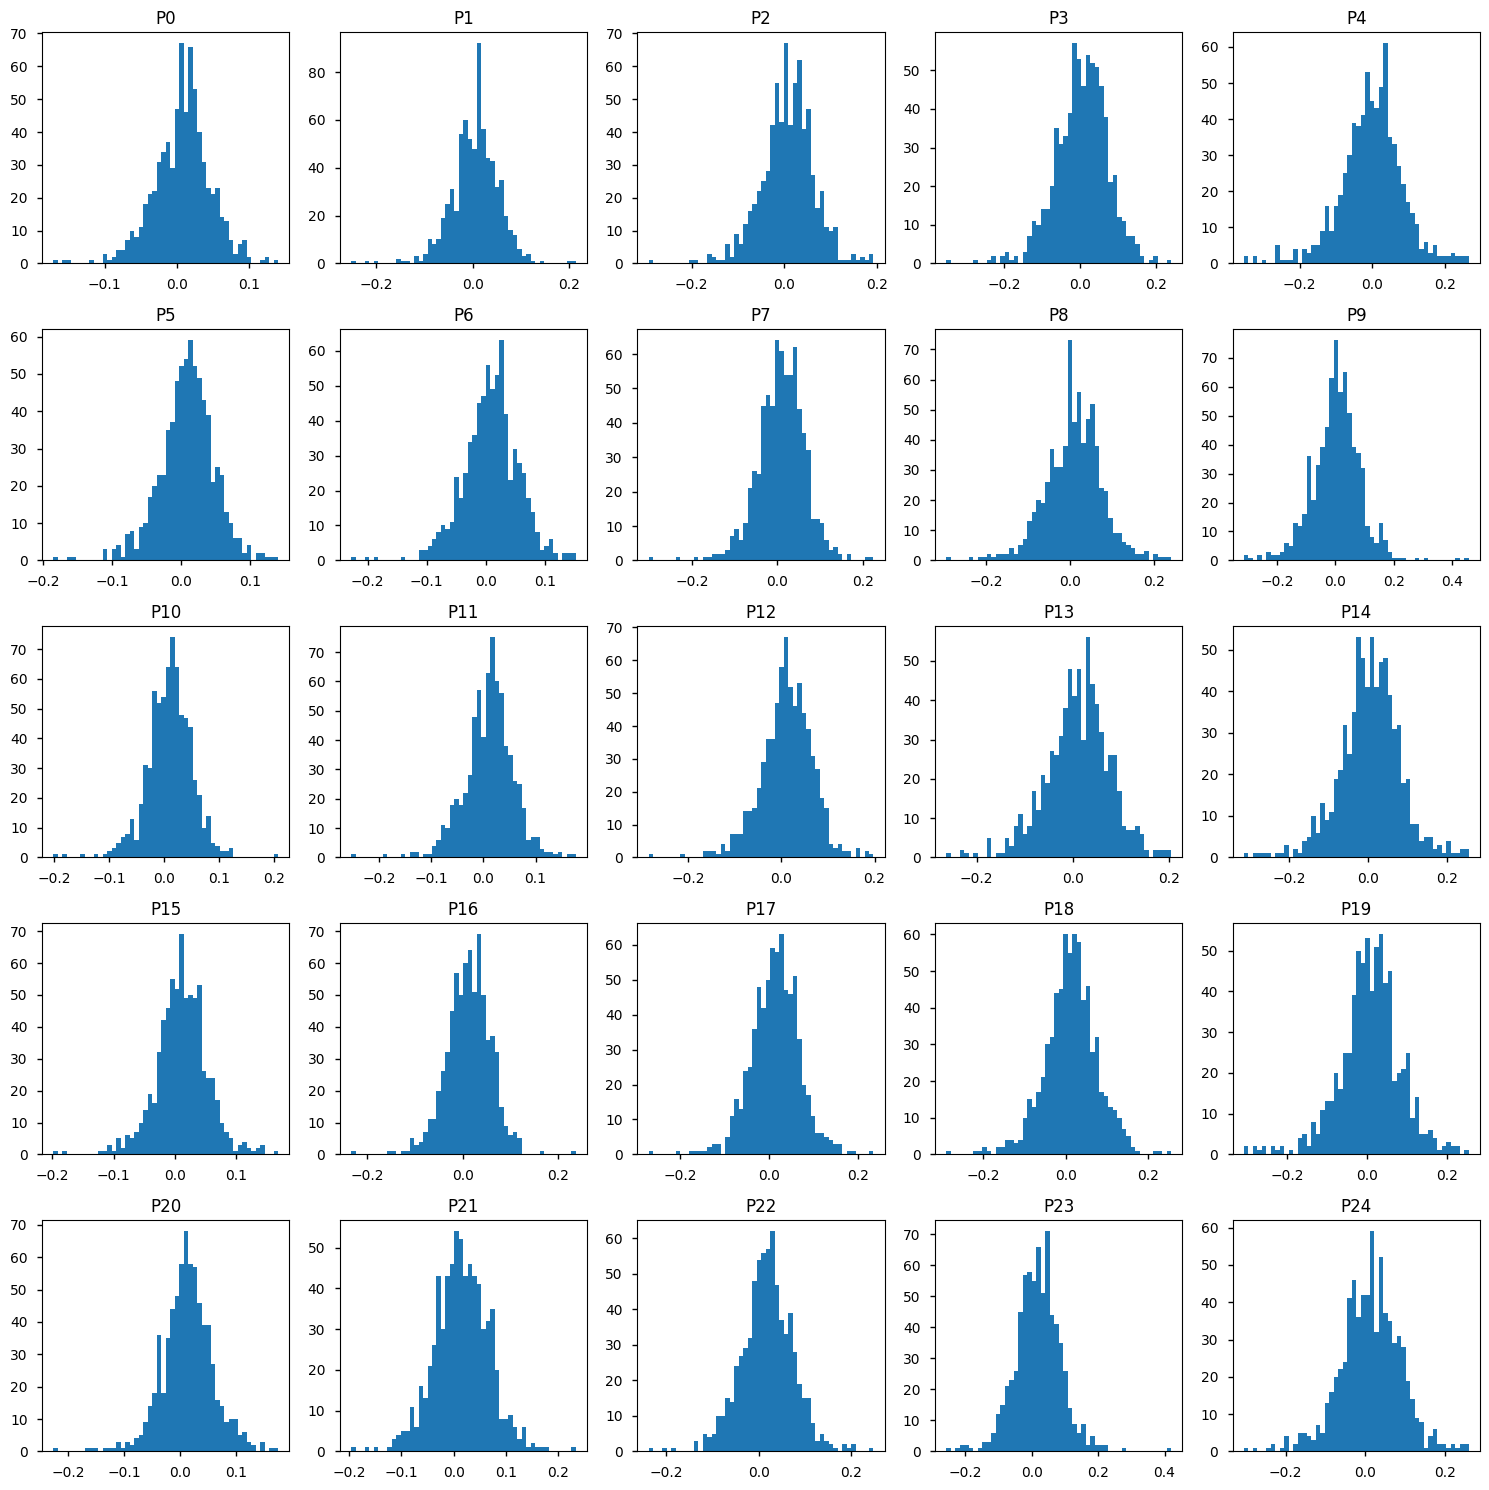

In [105]:
fig, axes = plt.subplots(5, 5, figsize = (15, 15))
axes = np.ravel(axes)

for i, col in enumerate(portfolio_ret.columns):
    axes[i].hist(
        portfolio_ret[col],
        bins = 50,
    )
    axes[i].set_title(f"P{i}")

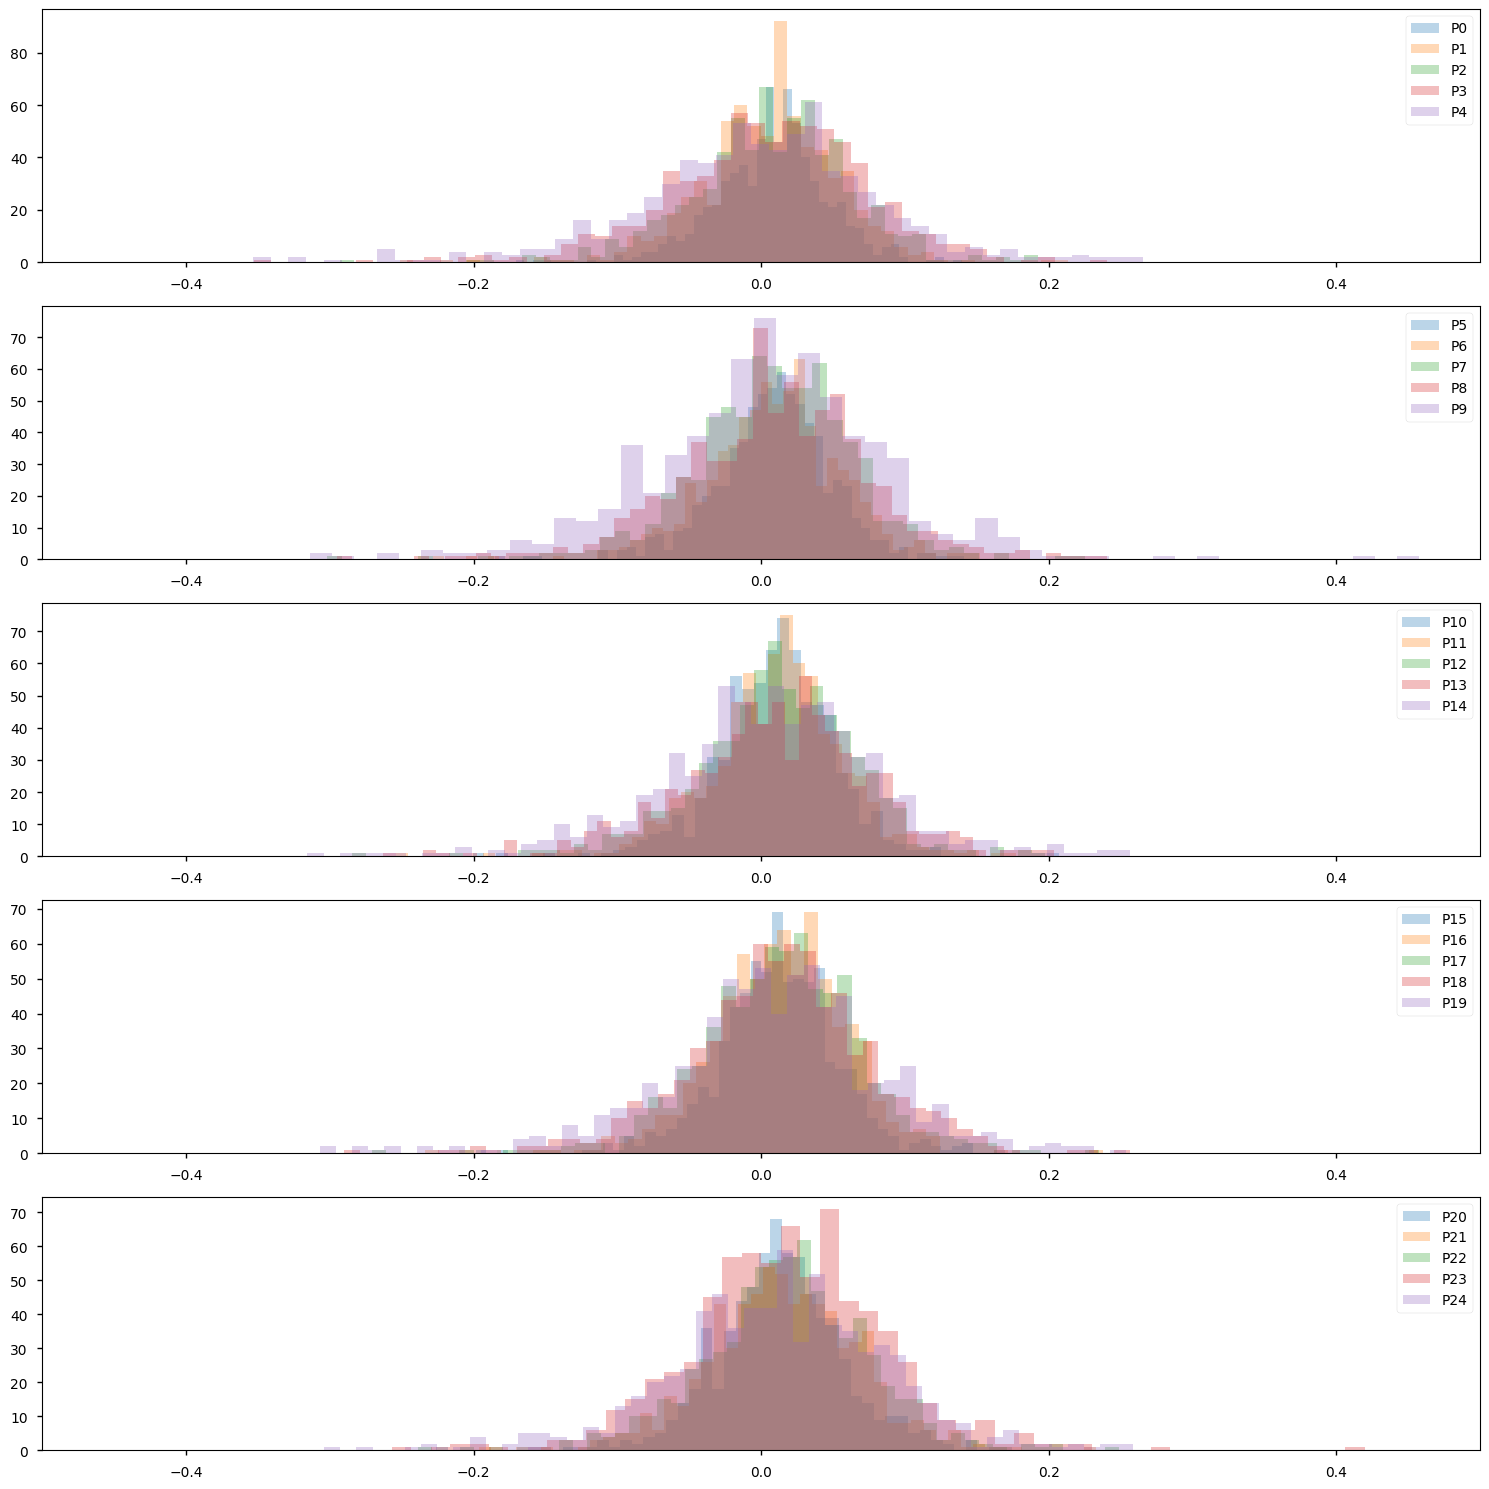

In [106]:
fig, axes = plt.subplots(5, 1, figsize = (15, 15))


for i, col in enumerate(portfolio_ret.columns):
    axes[i // 5].hist(
        portfolio_ret[col],
        bins = 50,
        label = f"P{i}",
        alpha = .3
    )

for i in range(5):
    axes[i].legend()
    axes[i].set_xlim(-0.5, 0.5)

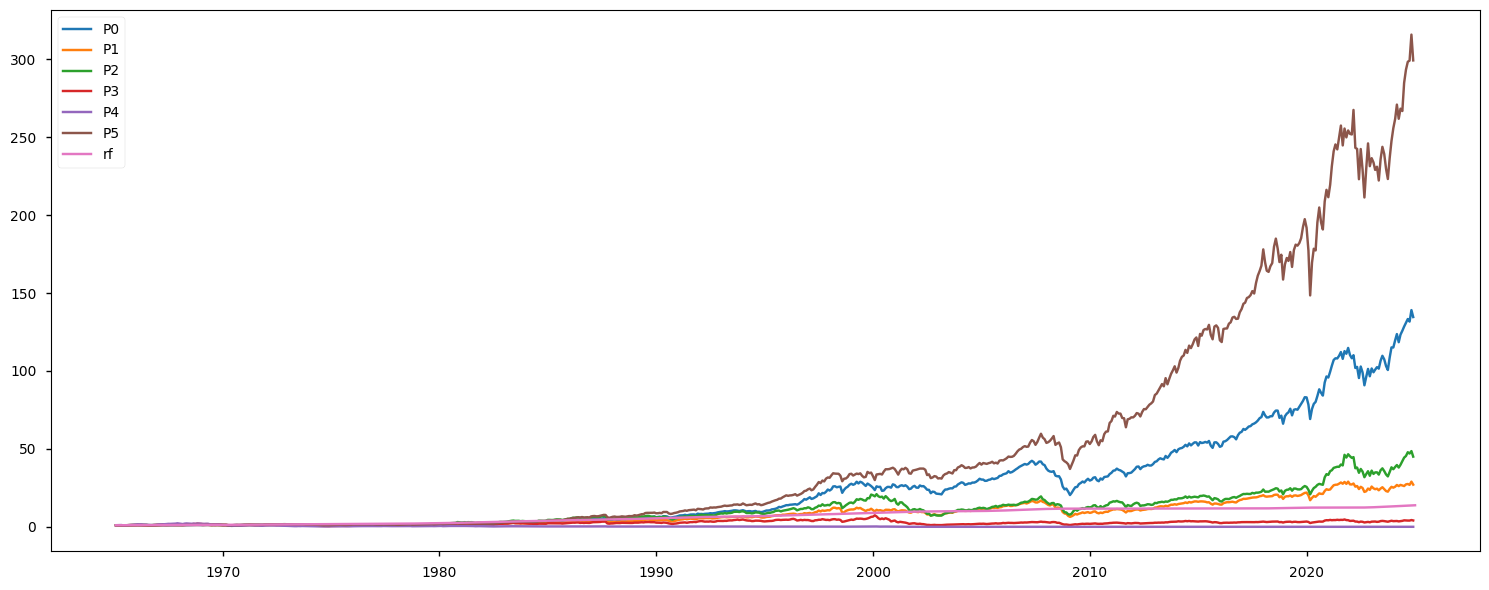

In [152]:
fig, ax = plt.subplots(1, 1, figsize = (15, 6))
for i, col in enumerate(portfolio_ret.columns):
    if i > 5:
        continue
    ax.plot(
        (portfolio_ret[col]+1).cumprod(),
        label = f"P{i}"
    )

ax.plot(
    (factors['rf'] + 1).cumprod(),
    label = 'rf'
)

ax.legend(loc = 'upper left')

In [186]:
factors = (
    conn.raw_sql(
        f"""
        SELECT dateff, mktrf, smb, hml, rf
        FROM ff.factors_monthly
        WHERE dateff BETWEEN '{start}' AND '{end}'
        """,
        date_cols = ['dateff']
    )
    .set_index('dateff')
    .replace([np.inf, -np.inf], np.nan)
    .fillna(0)
    .astype(float)
)

factors

,mktrf,smb,hml,rf
dateff,,,,
1965-01-29,0.0354,0.0270,0.0012,0.0028
1965-02-26,0.0044,0.0355,0.0011,0.0030
1965-03-31,-0.0134,0.0189,0.0103,0.0036
1965-04-30,0.0311,0.0110,0.0066,0.0031
1965-05-28,-0.0077,0.0011,-0.0161,0.0031
...,...,...,...,...
2024-08-30,0.0161,-0.0355,-0.0113,0.0048
2024-09-30,0.0174,-0.0017,-0.0259,0.0040
2024-10-31,-0.0097,-0.0101,0.0089,0.0039


In [148]:
portfolio_ret

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
1965-01-31,-0.001792,0.010382,0.009963,0.019158,0.037689,-0.008133,0.035722,0.04835,0.033501,0.054984,...,0.020321,0.014769,0.044227,0.020533,0.031894,-0.000038,0.044184,0.027116,0.058181,0.013647
1965-02-28,-0.010812,-0.010946,-0.011094,-0.015143,0.016363,-0.02368,-0.007989,-0.03458,-0.016559,0.006146,...,-0.007062,0.006758,0.005109,0.022584,0.004226,-0.003118,0.001297,-0.002074,0.016284,0.012866
1965-03-31,0.024929,0.025021,0.036027,0.023862,0.057073,0.032709,0.035306,0.015347,0.039155,0.037379,...,0.038452,0.024476,0.043711,0.082163,0.024418,0.019868,0.013779,0.059762,0.065322,0.034635
1965-04-30,0.001111,-0.008755,-0.000838,-0.017006,0.023544,-0.014773,-0.00011,0.004251,-0.046961,-0.006308,...,-0.003247,0.002371,-0.012651,0.010626,-0.014202,-0.005831,-0.027605,-0.004625,-0.020237,-0.016432
1965-05-31,-0.036775,-0.049065,-0.057809,-0.095337,-0.159435,-0.026289,-0.053249,-0.051861,-0.084273,-0.111317,...,-0.057067,-0.043578,-0.058088,-0.091995,-0.124466,-0.052132,-0.071354,-0.089291,-0.081145,-0.130347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-31,0.018943,0.009514,0.053049,-0.011512,0.044152,0.017437,0.018267,0.005662,0.03435,0.076946,...,0.030063,0.019428,0.020646,0.007322,0.049314,0.019111,0.005547,0.015374,0.01223,0.103535
2024-09-30,-0.012503,-0.021422,-0.017739,-0.000914,-0.027695,0.002422,-0.029416,-0.007889,0.009437,-0.033246,...,-0.015116,-0.008388,-0.020539,-0.024977,0.049352,-0.01055,-0.020643,-0.015071,-0.052238,-0.011157
2024-10-31,0.056116,0.077248,0.033521,0.080521,0.265488,0.055783,0.091238,0.045566,0.075371,0.089762,...,0.055158,0.065457,0.0517,0.089568,0.000946,0.024169,0.051782,0.062835,0.085701,-0.013197
2024-11-30,-0.032048,-0.066058,-0.073253,-0.058866,0.0382,-0.052399,-0.013023,-0.036439,-0.062425,-0.044836,...,-0.053662,0.009738,0.016553,-0.038785,-0.027847,-0.034292,-0.048811,-0.051094,-0.04078,-0.045202


In [159]:
portfolio_ret = portfolio_ret.sort_index()
factors = factors.sort_index()

portfolio_ret_reset = portfolio_ret.reset_index().rename(columns={'index': 'date'})
factors_reset = factors.reset_index().rename(columns={'dateff': 'date'})

merged_df = pd.merge_asof(
    portfolio_ret_reset,
    factors_reset,
    on='date',
    direction='backward'  # get the most recent factor date <= portfolio date
)

merged_df.set_index('date', inplace=True)

(719,)
(719, 3)


array([0.0016771450544270676, 0.05365910422662905, 0.052808071430613966,
       0.008265006168660289], dtype=object)

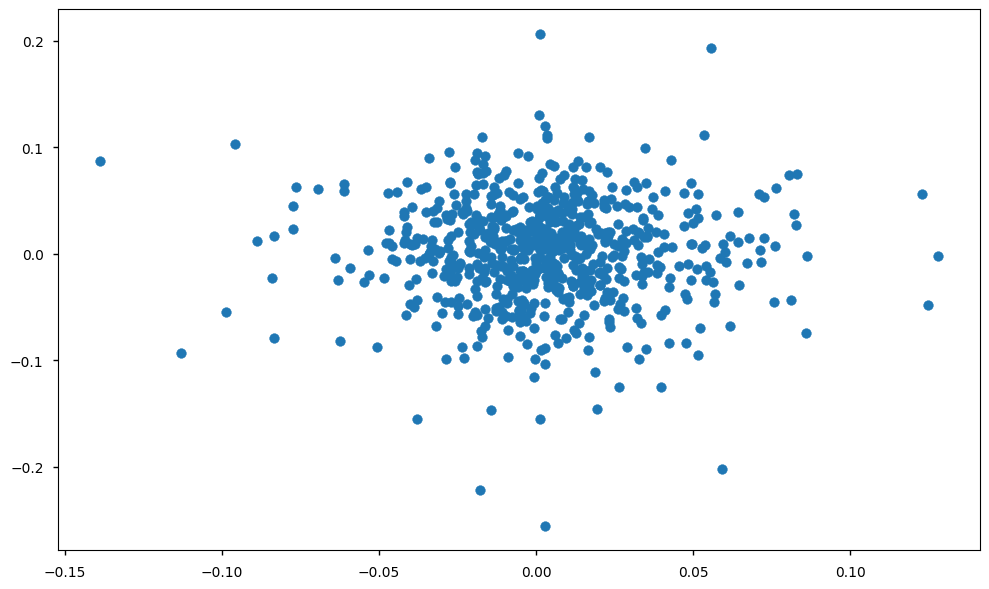

In [199]:
y = (merged_df[1] - merged_df['rf'])[:-1]
X = np.asarray(merged_df[['mktrf', 'smb', 'hml']])[:-1]

print(y.shape)
print(X.shape)

plt.scatter(
    X[:,2],
    y
)


# res = sm.OLS(
#     np.asarray(p1_ex_ret)[:-1], 
#     sm.add_constant(np.asarray(merged_df[['mktrf', 'smb', 'hml']][:-1]))
# ).fit()



res.params

In [ ]:
alphas = pd.DataFrame({
    "portfolio": np.arange(25),
    "abnormal_ret" : np.zeros(25)
}).set_index('portfolio')

for i in range(25):
    y = np.asarray(erged_df[i] - merged_df['rf'])[:-1]
    X = np.asarray(merged_df[['mktrf', 'smb', 'hml']])[:-1]
    X = sm.add_constant(X)
    res = sm.OLS(y, X).fit()
    alphas.loc[i]['abnormal_ret'] = res.params[0]




/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_53000/3002503077.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  alphas.loc[i]['abnormal_ret'] = res.params[0]
/var/folders/sp/cw_2m19j25xbvgpdjz48gclh0000gn/T/ipykernel_53000/3

In [161]:
alphas['abnormal_ret']

portfolio
0     0.004005
1     0.001677
2     0.003030
3     0.000296
4    -0.006306
5     0.005042
6     0.004857
7     0.004738
8     0.005301
9    -0.000339
10    0.006445
11    0.006964
12    0.007174
13    0.006037
14    0.001163
15    0.008199
16    0.010077
17    0.010021
18    0.008941
19    0.003469
20    0.009120
21    0.011674
22    0.014560
23    0.014795
24    0.008406
Name: abnormal_ret, dtype: float64

<BarContainer object of 25 artists>

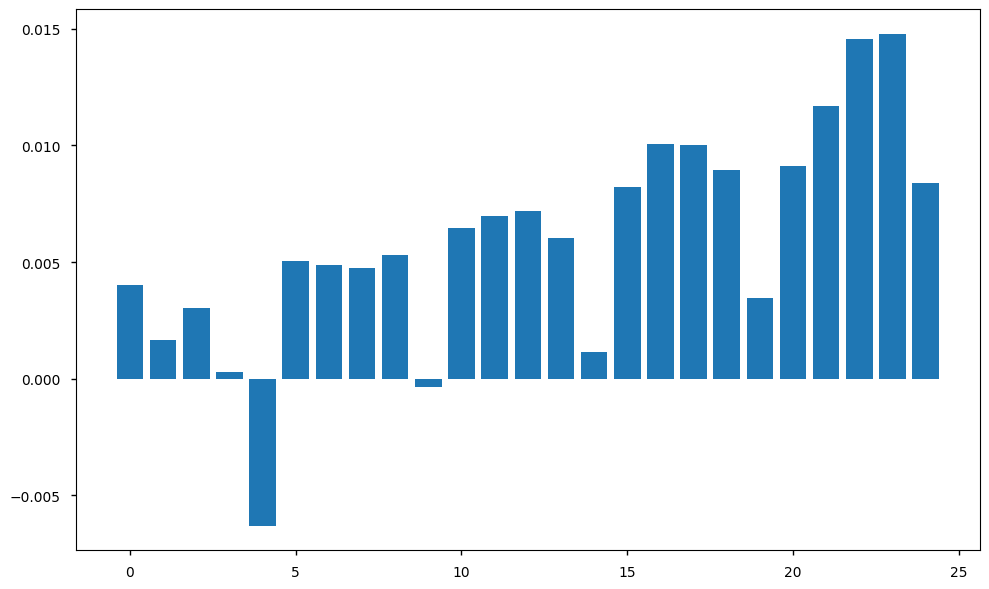

In [ ]:
plt.bar(
    np.arange(25),
    alphas['abnormal_ret']
)

<Axes: >

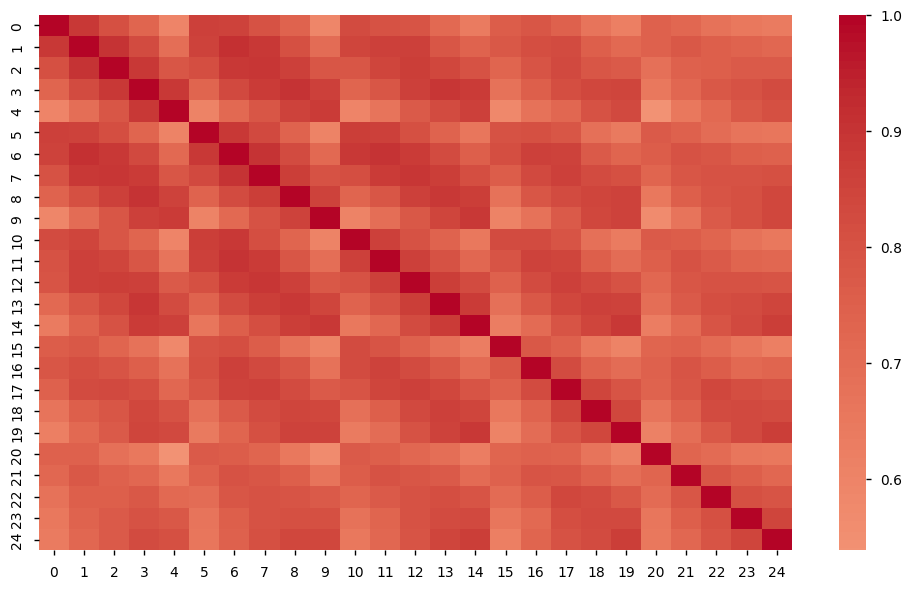

In [164]:
sns.heatmap(merged_df.iloc[:, :25].corr(), cmap='coolwarm', center=0)